In [2]:
import numpy as np


In [31]:
def sigmoid(Z):
    A=1/(1+np.exp(-Z))
    cache=Z
    
    return A,cache

def backSigmoid(dA,cache):
    Z=cache
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s)
    assert (dZ.shape == Z.shape)

    return dZ

In [4]:
def relu(Z):
    A = np.maximum(0,Z)    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)    
    dZ[Z <= 0] = 0    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#from testCases_v4 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [8]:
def initialize_parameters(n_x, n_h, n_y):
   
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [67]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros(shape=(layer_dims[l],1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [10]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
   
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             activation='relu' )
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation='sigmoid' )
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [68]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))    
    cost = np.squeeze(cost)      #  this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [56]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ , A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [34]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = backSigmoid(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [61]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [36]:
def update_parameters(parameters, grads, learning_rate):
   
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

In [37]:
def load_data():
    train_dataset = h5py.File('CourseraDaraSets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('CourseraDaraSets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [38]:
def predict(X, y, parameters):
   
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
   
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


In [39]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


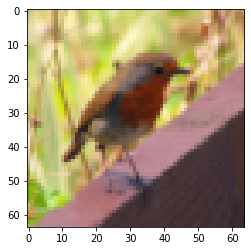

In [41]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [42]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [43]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [44]:
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [45]:
layers_dims = [12288, 20, 7, 5, 1]

In [46]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
  
    np.random.seed(1)
    costs = []                         # keep track of cost
    

    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL,Y)
    
        grads = L_model_backward(AL,Y ,caches) 
        parameters = update_parameters(parameters,grads,learning_rate)
                
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


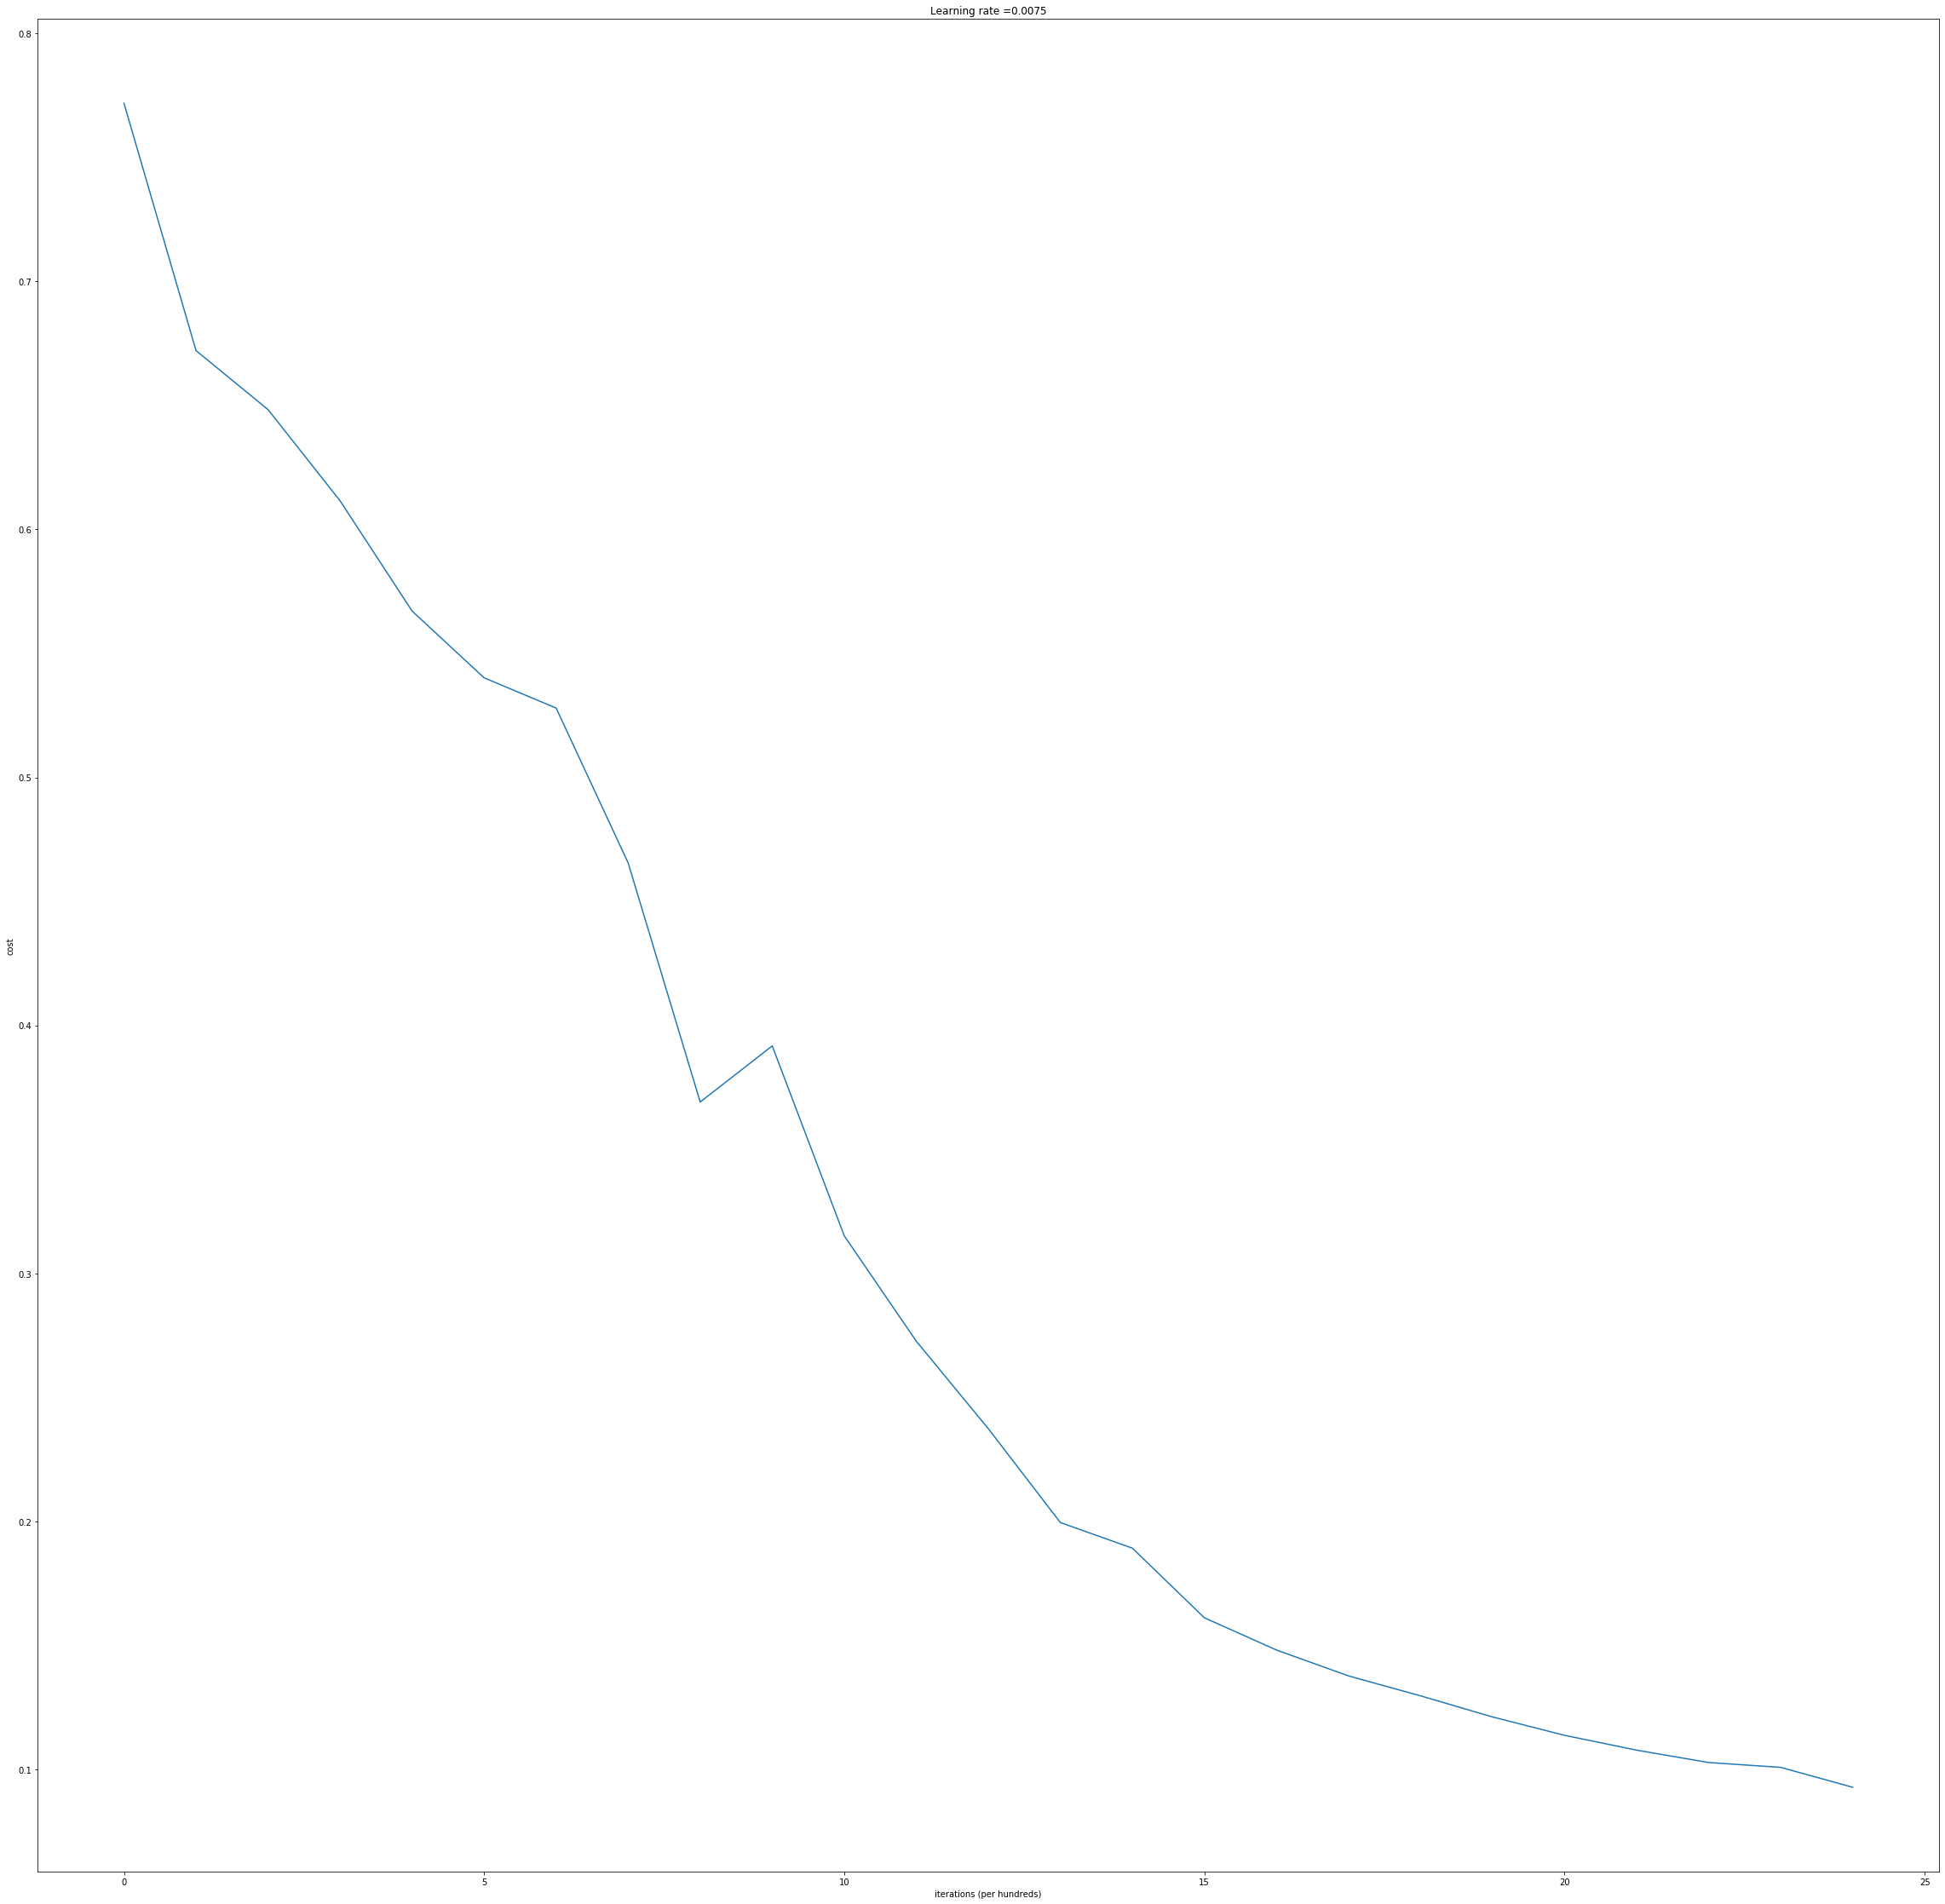

In [69]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [70]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [71]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


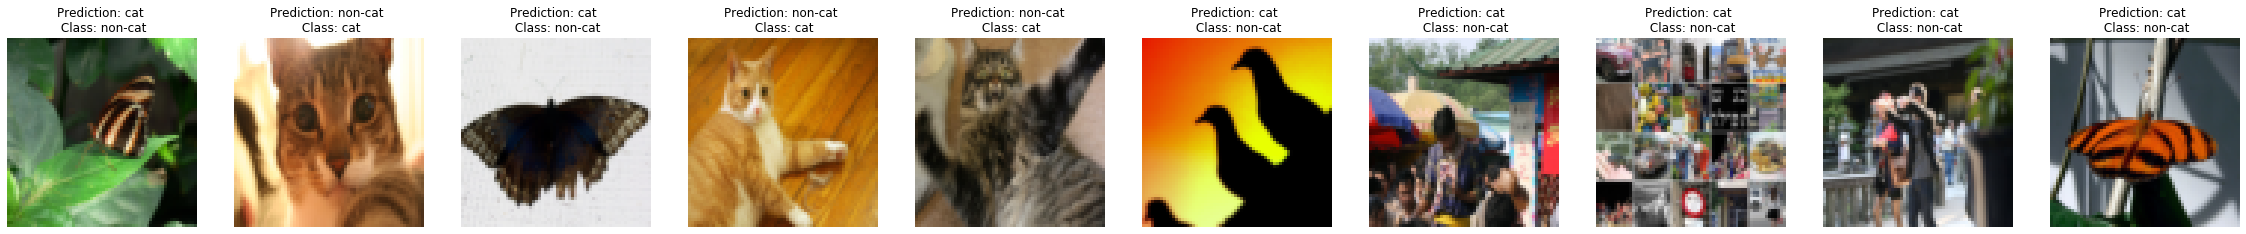

In [72]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

g:\computational neural networks for vision recognition\cnn\venv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """
g:\computational neural networks for vision recognition\cnn\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


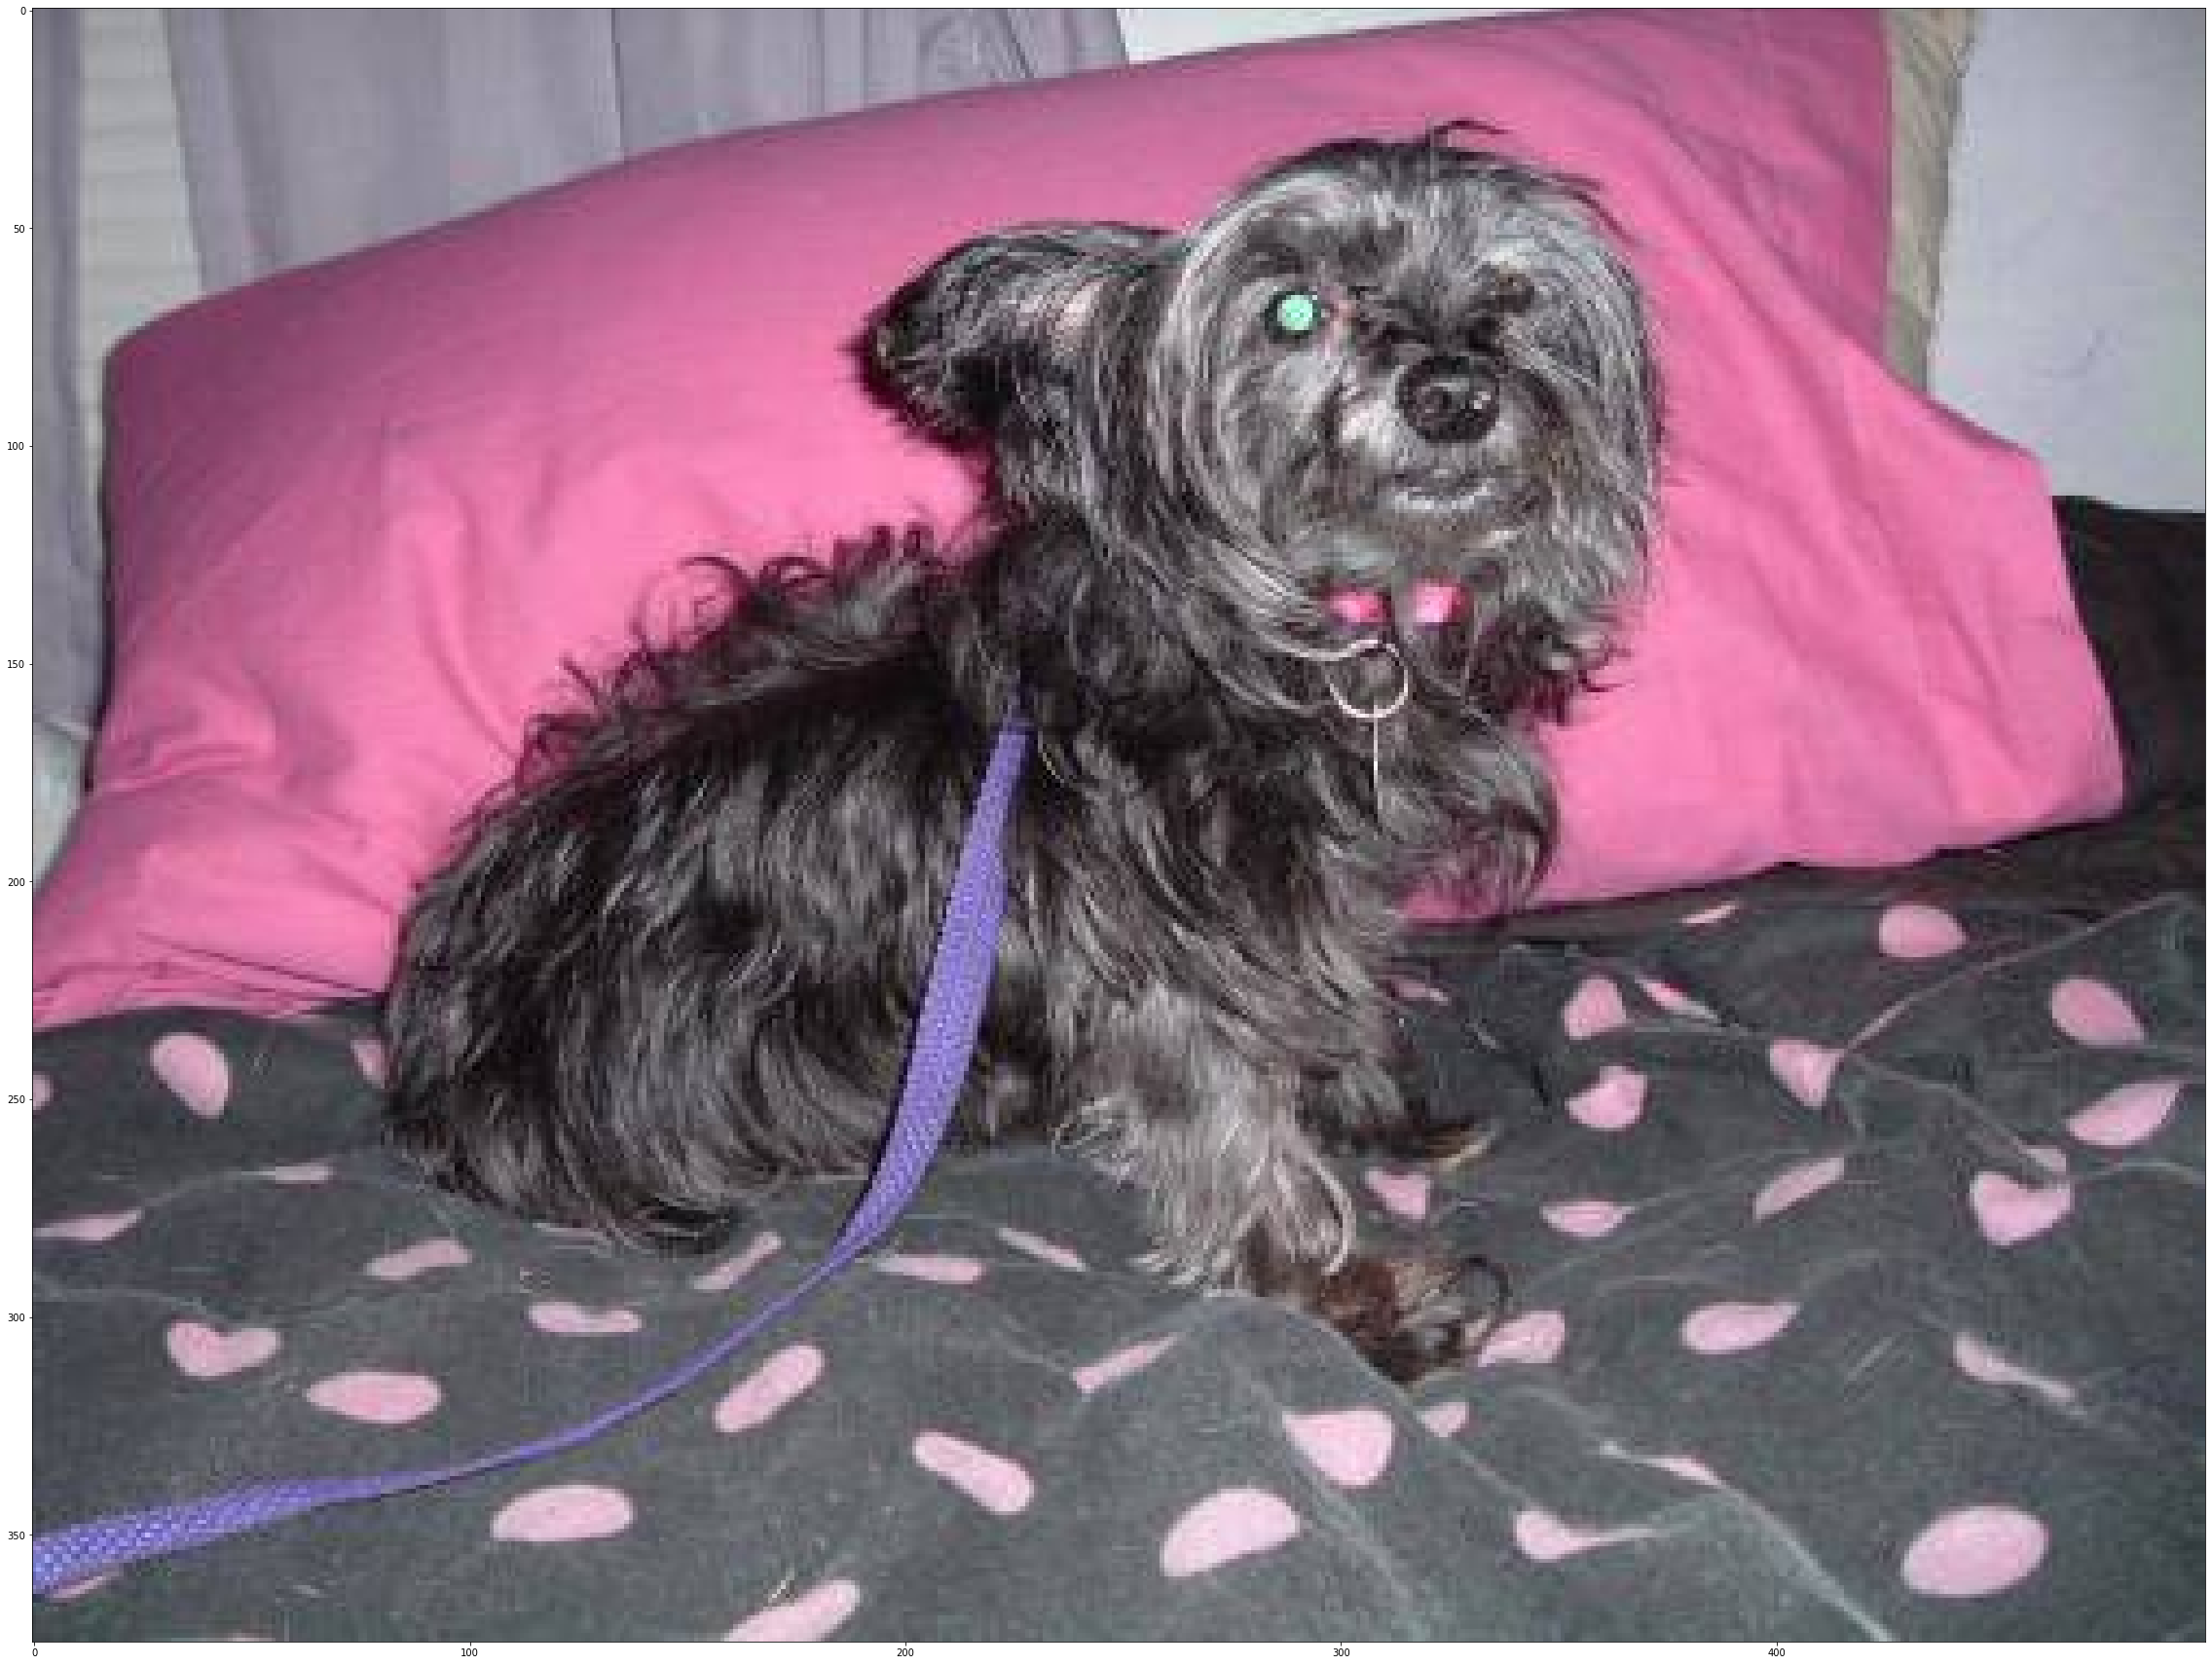

In [78]:
my_image = "dogs-vs-cats/train/Dog/dog.0.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")